<a href="https://colab.research.google.com/github/oleo2003/group_5_repo/blob/main/3)_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(**Note:**
Click on the button that reads *“Open in Colab”* to open this code in Google Colab. Once open in Google Colab, you can make a copy of the notebook in your personal drive and run the code by clicking a little triangle/arrow to the left of each code block.)

# **Random Forest**
## ***Objectives for this Notebook***
- Familiarize with the basics of how tree models works, specifically Random Forests.
- Implementing functions to run Random Forest to Moragadivand's dataset.

<a name="tree-methods"></a>
Random Forests belong to a group of algorithms known as tree methods. A Random Forest model is also an ensemble method. Ensemble methods use an arrangement of weaker predictor models (in this case Decision Trees) to produce a stronger model (in this case Random Forest). The basis of all tree methods is the Decision Tree. For those unfamiliar with tree methods, we have some definitions below:

![tree_forest.png](https://drive.google.com/uc?export=view&id=1TBxIoL7K4WeXhegZZAvURJSxREw-Uqto)

- A **Decision Tree (left)** is a supervised learning algorithm that can be used for regression (predicting a continuous variable) or for classification (predicting a categorical variable). Our task is to classify each *E. coli* sample into Resistant (**R**) or Susceptible (**S**) classes.
We can picture a tree upside down, starting with the root on top and stopping at the leafs at the bottom, the different squares represent decision thresholds, if the isolate passes the threshold, then we move down the tree following the "yes" arrow, if not then we follow the "no" arrow to the next square down below until a classification decision is finally made.

- A **Random Forest (right)** is the combination of several Decision Trees outputs, each tree classifies all samples independently and the final decision for each sample is made based on the decision of the majority of trees. Each tree inside the Random Forest is created by selecting a random subset of features instead of using all the features.

- **Bagging:** To make a prediction with a Random Forest model, we average or agregate the results from all the different Decision Trees we have created for a final prediction. This process is called Bagging. Bagging is useful because it reduces overfitting and variance.
  
If we chose to use a combination of features such as: **GY** (Gene Presence or Absence + Year of isolation), each tree would randomly use only some columns from the total amount of column features (G + Y features).

We will explain further details on the structure of Random Forests as we code along to further clarify how nodes are chosen and how it uses the outputs of all trees for a final decision.








### **1) Importing Packages needed**

**NOTE:** Similar code as in previous notebook

In [1]:
# Data manipulation imports for ML
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype

# Import packages for Random Forest model and hyperparameter tuning
from sklearn.ensemble  import RandomForestClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold, KFold

# Imports for model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, get_scorer_names
from sklearn.metrics import f1_score, make_scorer, accuracy_score, recall_score, precision_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

# Imports for data visualization
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import graphviz

# Imports for file management
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **2) Loading CSV file and creating dataframes for each antibiotic**

Similar to the previous notebook we loaded the dataframe created in the first notebook of this tutorial, then we create a dataframe for each antibiotic. To check that our function works we will test it using "CTX" antibiotic.

**NOTE:** Same code as in previous notebook

In [2]:
# Loads csv file as a dataframe
filepath = '/content/drive/My Drive/EColi_ML_CSV_files/'

# reads csv file as a dataframe
All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")
All_Drugs_df.head()

/tmp/ipython-input-766915696.py:5: DtypeWarning: Columns (5,6,7,8,10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")


,MLST,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
0,ST68,11679_6#21,2001.0,S,NaN,NaN,S,S,S,R,...,0,0,0,0,0,0,0,0,0,0
1,ST652,11658_6#85,2005.0,S,S,NaN,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,ST95,11657_6#45,2005.0,S,S,NaN,R,R,R,S,...,0,0,0,0,0,0,0,0,0,0
3,ST73,11658_4#53,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,ST73,11658_4#54,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0


### **3) Separating each Drug Dataframe into 4 sections : Training (features and labels) and Testing (features and labels)**

**NOTE:** Same code as in previous notebook

In [3]:
# Separating each dataframe into Labels and Features for training and testing data.
# Our function uses the handy train_test_split() function.

def Split_train_test_antibiotic(drug):
  #here we make a list of the columns we want to keep: the column for the isolate, the column for the drug we are interested in and all features (starting from column 15).
  df_list = [All_Drugs_df[["MLST","Isolate",drug,"Year"]], All_Drugs_df.iloc[:,15:]]

  #here we create a data frame with just the columns we wanted to keep.
  Drug_df = pd.concat(df_list, axis=1)

  #here we drop all rows with missing data
  Drug_df = Drug_df.dropna()

  # Creating a dictionary to store each antibiotic datasets
  Train_test_dic = {}

  # Defining the label columns
  labels = Drug_df[drug]

  # Defining features columns
  features = Drug_df.drop(columns=[drug])

  # Separating training (features and labels) and testing (features and labels) datasets
  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=42, stratify=labels)

  # storing each data chunk in a dictionary
  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test

  return Train_test_dic

Below we implement the function **Split_train_test_antibiotic()** and then print how many are resistant and how many are Susceptible for the antibiotic CTX.

In [4]:
# Implementing the function Split_train_test_antibiotic() for CTX example
CTX_Train_test_dic = Split_train_test_antibiotic("CTX")

# checking the shape of each dataframe or series stored in the dictionary created for drug CTX
print("CTX")
for k, df in CTX_Train_test_dic.items():
  print(k, df.shape)
  # counting how many of the labels have susceptible versus resistant ones
  if k.startswith("label"):
    print(df.value_counts())

CTX
labels_train (1440,)
CTX
S    1138
R     302
Name: count, dtype: int64
features_train (1440, 17201)
labels_test (361,)
CTX
S    285
R     76
Name: count, dtype: int64
features_test (361, 17201)


Notice that just like before we have more *E. coli* samples that are Susceptible, rather than Resistant, therefore we need to remember to pay attention to the metrics of precision and recall for each of these classes rather than just looking at the overall accuracy. **The total number of training observations is 1440.**

### **4) Creating different combination of features before training**

**NOTE:** Same code as in previous notebook

In [5]:
# making a list of combinations of data sources we would like to test in our ML models
combo_list = ['Y', 'G', 'GY']

# making a function that creates different feature combinations of the predictor features
def combo_feat(features_df, drug, combo):

  # Isolating Year as a feature and
  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  # creating Gene precence column filters for features_df
  gene_presc_filter = [col for col in features_df.columns if col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]

  if combo == 'Y':
    df_list = [features_df[['MLST','Isolate']], year_feat]
    Y_feat_df = pd.concat(df_list, axis=1)
    Y_feat_df = Y_feat_df.drop(columns=['Isolate'])
    return Y_feat_df

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = G_feat_df.drop(columns=['Isolate'])
    return G_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], year_feat, gene_presc_feat]
    GY_feat_df = pd.concat(df_list, axis=1)
    GY_feat_df = GY_feat_df.drop(columns=['Isolate'])
    return GY_feat_df

In [6]:
# Implementing combo_feat() function created for training data
CTX_G_train_df = combo_feat(CTX_Train_test_dic['features_train'],"CTX","G")

# looking only at the feature column names for the combination for "G" for drug "CTX" for training data
CTX_G_train_df.columns

Index(['MLST', 'yeiU', 'yhhS', 'ybaE', 'eutR', 'ibrB', 'ytfP', 'aslB', 'narQ',
       'tolR',
       ...
       'group_48768', 'group_48873', 'group_48916', 'group_48933',
       'group_48937', 'group_48958', 'group_49020', 'group_49174',
       'group_49253', 'group_49257'],
      dtype='object', length=17199)

### **5) Creating Random Forest model and training it per feature combination**
In this step we can take a closer look at the structure of a Random Forest. First we will create a function that will train our Random Forest to learn to predict Resistance or Susceptibility for a particular strain. Because our function does not specify how many trees to use, the default is 100 Decision Trees created.

- We have set a random state in our in the Random Forest Classifier in order to get replicable results for this tutorial.

In [7]:
# creating Random Forest model function
def run_RF(feat_train, lab_train, drug, combo):
  print(drug +" Training combo: "+ combo)
  feat = feat_train.drop(columns=["MLST"])
  # creating Random Forest model
  RF = RandomForestClassifier(random_state = 42)
  # Training Random Forest Model
  RF = RF.fit(feat, lab_train)
  # Checking number of trees in the model
  print("Number of Decicion Trees in RF model:", len(RF))
  return RF

Below we will implement our function just as in previous parts, but then we will also take a look at one tree of the Random Forest, after training.

In [8]:
# implementing run_RF() for specific drug feature combination dataframe
RF_CTX_G_model = run_RF(CTX_G_train_df,CTX_Train_test_dic["labels_train"],"CTX","G")
RF_CTX_G_model

CTX Training combo: G
Number of Decicion Trees in RF model: 100


RandomForestClassifier(random_state=42)

Now we have trained our Random Forest model using only Gene Absence / Presence (G) features to predict resistance to the antibiotic CTX. Below we can graph for example the fourth tree (index=3). We have 100 trees, and python starts count from 0. Therefore the index would runs from 0 to 99.

In [9]:
# Setting the index of the tree we are interested in seeing
index= 3

# Drawing the tree by setting the Index and the depth of the tree we would like to draw
single_tree = tree.export_graphviz(RF_CTX_G_model.estimators_[index], out_file=None,
                                  feature_names=CTX_G_train_df.iloc[:,1:17199].columns,
                                  filled=True, rounded=True,
                                  special_characters=True,
                                  max_depth=None)
graph = graphviz.Source(single_tree)

The code below will store our complete Decision Tree graph as a pdf document. The file will be named based on the index you have chosen to draw, in this case it would be the tree at index 3. Notice that a single tree from our Random Forest can be very big. Make sure to look at the file that will be saved to a folder called "EColi_ML_Plots" in your Drive.

In [10]:
# Saving a single complete decision tree from our Random Forest model into our new directory
graph.render("/content/drive/MyDrive/EColi_ML_Plots/RF_Classification Tree #: "+ str(index))

'/content/drive/MyDrive/EColi_ML_Plots/RF_Classification Tree #: 3.pdf'

The code below on the other hand will let us view only the top part of the tree (only first 3 layers after the root node), you can control the display of the tree by changing the argument **max_depth**.
You can see here that the first node looks at whether an isolate carries the gene referred to as group_6670. The second node on the left looks at whether isolates carry a gene that is referred to as "hsdR".

#### **Parts of a Decision Tree**:

- **Root Node:** displayed at the very top of our Decision tree. It is considered as the most important feature from the random subset of feature columns that our Random Forest (RF) picked. Therefore, each tree in the RF is likely to have a different Root Node.

- **Intermediate Nodes:** the first 2 layers of intermediate nodes are being displayed. Similar to the Root Node it contains decision thresholds that eventually lead to a final prediction.

- **Leaf Nodes:** Not displayed in the trimmed version, but we can observe them in the pdf. The leaf nodes contain the final predictions within one tree of our RF. You can recognize them because there are no decision thresholds.

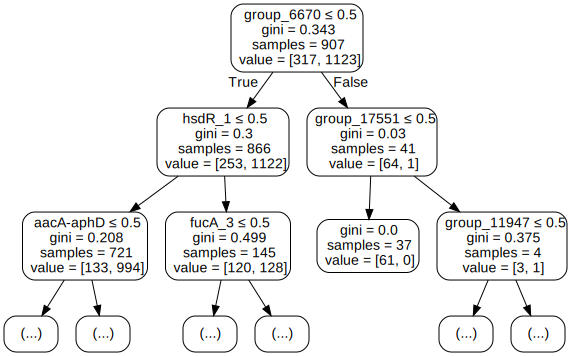

In [11]:
# Setting the index of the tree we are interested in seeing and how many layers to draw
index= 3

# Drawing the tree by setting the Index and the depth of the tree we would like to draw
chopped_tree = tree.export_graphviz(RF_CTX_G_model.estimators_[index], out_file=None,
                                  feature_names=CTX_G_train_df.iloc[:,1:17199].columns,
                                  filled=False, rounded=True,
                                  special_characters=True,
                                  max_depth=2)
graph = graphviz.Source(chopped_tree)
display(graph)

#### **Information within each Node**

Below is an schematic for each type of node and uses the fourth Decision Tree of our Random Forest. The type of information displayed in each node, has been labeled (A, B, C and D) only for the root node but it is present in all the root and intermediate nodes, the leaf nodes only contain B, C and D information. Below we will go over what each of the labeled information represent:

![tree-parts.png](https://drive.google.com/uc?export=view&id=1WN05o44tqflVq-GL_2uL_nQuLn3MiNEG)
***
**A) Decision Threshold:** These are essentially Boolean statement about a column feature that represents a threshold. If the statement is TRUE for a particular observation then we follow the left arrow to and if its false FALSE then we follow the right arrow to the next node. The Decision Threshold is only present in the root and intermediate nodes. In the picture example the thresholds would be: <font face="monospace">group_6670 $\leq$ 0.5 (root node), hsdR_1 $\leq$ 0.5 (intermediate node), aacA-aphD $\leq$ 0.5
 (intermediate node)</font>, etc

The features from the gene presence absense table (gene names or group numbers) are categorical variables that have already been one-hot encoded, where 1 means that the ortholog gene is present and 0 means that it is not. Therefore if an observation is $\leq$ 0.5 for those thresholds then it means this gene is not present and we would follow the left arrow.

**NOTE:** TRUE is equivalent to **yes (left arrows)** and FALSE equivalent to **no (right arrows)** from the [image](#tree-methods) displayed at the begining of this notebook.

***
**B) Gini Impurity:** is a measure of purity of the classification. It is a number between 0 and 1, where a value of 0 means that all samples belong to one particular class (purest node); whereas a value of 1 means all samples are distributed equally among the classes (least pure node). Here is a link about [Gini Impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), if you are interested in the calculation and specific formula behind it.

In our graph, we see that the root node has <font face="monospace">Gini = 0.343</font> and as we go lower on the tree this value also lowers. In the leaf node we see <font face="monospace">Gini = 0.0</font> because the remaining observations in the leaf belong to only one class, the Resistance (R) one. This means that all the observations that have the gene <font face="monospace">group_6670</font>(root node) but not the gene <font face="monospace">group_17551</font>(intermediate node) are classified exclusively as Resistant in this particular tree of our Random Forest model.
***
**C) Samples:** Is the number of unique observations from the original training dataset before the bagging proceedure. In the image we can see that the intermediate node with the threshold group_17551 $\leq$ 0.5 has 41 unique samples and it is later split into a leaf node with 37 unique samples and another intermediate node with 4 samples (41 = 37 + 4).
***
**D) Values:** is a list of numbers showing the amount of actual observations classified AFTER the bagging proceedure (random sampling of training observations with replacement + aggregation). We only have 2 classes, so the length of this list is just 2 numbers, we can expect a list of 3 if there are 3 classes to classify, 4 if there are 4 classes, etc.

In the image we can see that as we go down the decision tree the Resistant observations (in red) in the node with the Decision threshold <font face="monospace">hsdR_1 $\leq$ 0.5</font> has <font color="red">253</font> observations classified  as Resistant, then uppon splitting into 2 intermediate nodes this value is also split into <font color="red">133</font> and <font color="red">120</font>. The same thing happens for the Susceptible split in this node <font color="blue">(1122 = 994 + 128) </font>.

**NOTE:** Usually for a regular Decision Tree the sum of the list of numbers in values would add up to the sample number BUT in the case of a Random Forest Decision Tree the **Samples** only count the unique observations, whereas our **Values** include the repeated copies from the bagging proceedure as well .
***
If you are not sure which number corresponds to a particular class, below we can access the index of the values shown in each node. As we can see the first index is Resistant (0) and the second index is Susceptible (1):

In [12]:
# line to see what classes belong to a particular index in the Values.
RF_CTX_G_model.classes_

array(['R', 'S'], dtype=object)

### **6) Making predictions from Random Forest model**

The code chunks below will attempt to show us how Random Forests make their predictions using in our case 100 Decision Trees. An important distinction between a Decision Tree and Random Forest is to consider how the trees are generated within the Random Forest. In Random Forest there are 2 randomizations happening when they create the trees:
- Random selection of observations from the total training data (rows)
- Random selection of features from the feature combination we have chosen, in this case it would be G (columns)

**NOTE:** Same code as in previous notebook

In [13]:
# creating a function using the model created and trained and the feature combinations from testing data
def predict(RF_combo_Model, features_test):
  feat = features_test.drop(columns=["MLST"])
  labels_pred = RF_combo_Model.predict(feat)
  if is_numeric_dtype(labels_pred):
    # tranforming labels from numbers to letters
    lab_pred_t = labels_pred.astype('O')
    lab_pred_t[lab_pred_t==0] = 'R'
    lab_pred_t[lab_pred_t==1] = 'S'
    return lab_pred_t
  else:
    return labels_pred

Below we implement first the function "combo_feat" to specify which testing features we want to use to make our predictions. Then we use our predict function to finally get the predictions made by the Random Forest.

In [14]:
# Implementing combo_feat() function created for testing data
CTX_G_test_df = combo_feat(CTX_Train_test_dic['features_test'],"CTX","G")

# Implementation of the predict() function using the feature combination "GY"
CTX_G_labels_pred = predict(RF_CTX_G_model,CTX_G_test_df)

# observe how many predictions were made for each category "R" and "S"
print("Labels predicted: ", np.unique(CTX_G_labels_pred, return_counts=True))

Labels predicted:  (array(['R', 'S'], dtype=object), array([ 65, 296]))


The final predictions from the Random Forests were 65 Resistant and 296 Susceptible. However to see how the final decisions were made, we can check how each tree makes predictions for **just the first observation** in the features test data. The code below provides a counter for trees that voted Susceptible vs the ones that voted Resistant for the third observation.

In [15]:
# Code below shows the number of trees that predicted one of the two outcomes
votes_for_R = 0 #we start with 0 trees "voting" for R
votes_for_S = 0 #and 0 trees "voting" for S

#loop over each of the trees in the random forest
for i in range(0,len(RF_CTX_G_model)):
  #get a prediction from one tree
  pred = RF_CTX_G_model.estimators_[i].predict(CTX_G_test_df.iloc[0,1:17199].to_numpy().reshape(1,-1))

  # if the prediction is 0 then it is "R"
  if pred == 0.00:
    votes_for_R = votes_for_R + 1

  #if the prediction is 1 then it is "S"
  else:
    votes_for_S = votes_for_S + 1
# Counting the number of trees that predicted R and the ones that predicted S
print("Number of trees that voted Resistant: ",votes_for_R)
print("Number of trees that voted Susceptible: ",votes_for_S)

Number of trees that voted Resistant:  89
Number of trees that voted Susceptible:  11


Below we can check the prediction by the Random Forest, for the first observation as well. Because the majority of the trees voted for Resistance (R), we can see that our Random Forest ends up predicting R as well.

In [16]:
# prediction using the second value of our test features
pred = RF_CTX_G_model.predict(CTX_G_test_df.iloc[0,1:17199].to_numpy().reshape(1,-1))
print("Prediction by Random Forest: ", pred)

Prediction by Random Forest:  ['R']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### **7) Evaluating our model using a confusion matrix and metrics**

**a) Creating evaluate() function and implementing it:**

Similarly to the previous notebook, we will evaluate our RF model by using a Confusion Matrix and respective metrics. Below is a quick review of these, remember that there is one Accuracy score, but Recall and Presicion should have as many sets as classes our model its trained to predict:

|<font size=3>Metrics|<font size=3>General formula|<font size=3> Formula for 2 classes|
|--|:-:|:-:
|<font size=3>**Accuracy**|<font size=3>$\frac{Correctly \ classified}{All \ Predicted}$|<font size=3>$\frac{TP + TN}{TP + TN + FN + FP}$|
|<font size=3>**R Recall:**|<font size=3>$\frac{Correctly \ classified \ as \ R}{All \ Actual \ R}$|<font size=3>$\frac{TP}{TP + FN}$|
|<font size=3>**R Precision:**|<font size=3>$\frac{Correctly \ classified \ as \ R}{All \ Predicted \ R}$|<font size=3>$\frac{TP}{TP + FP}$|

In [17]:
# Creating a function that evaluates our model using our actual and predicted data
def evaluate(RF_combo_model, labels_test, labels_pred, cf= True, show_results=True):
  report = classification_report(labels_test, labels_pred, output_dict = True)
  if cf == True:
    cm = confusion_matrix(labels_test, labels_pred, labels=np.unique(labels_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(labels_pred))
    disp.plot()
    plt.grid(False)
    plt.show()
  if show_results == True:
    print("Results")
    print('Accuracy:',report['accuracy'])
    print('R recall:',report['R']['recall'])
    print('S recall:',report['S']['recall'])
    print('R precision:',report['R']['precision'])
    print('S precision:',report['S']['precision'])
  return [report['accuracy'], report['R']['recall'], report['S']['recall'], report['R']['precision'], report['S']['precision']]

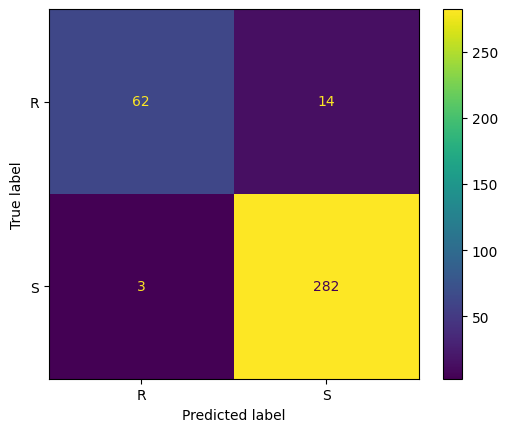

Results
Accuracy: 0.9529085872576177
R recall: 0.8157894736842105
S recall: 0.9894736842105263
R precision: 0.9538461538461539
S precision: 0.9527027027027027


In [18]:
# implementing the evaluate() function
Model_Report = evaluate(RF_CTX_G_model, CTX_Train_test_dic['labels_test'],CTX_G_labels_pred)

**b) Create a feature importance graph showing which features were the most important**

The gini impurity is a metric used to determine which features are more important than others. Below we will learn to graph the feature importance for the model we have been working on.

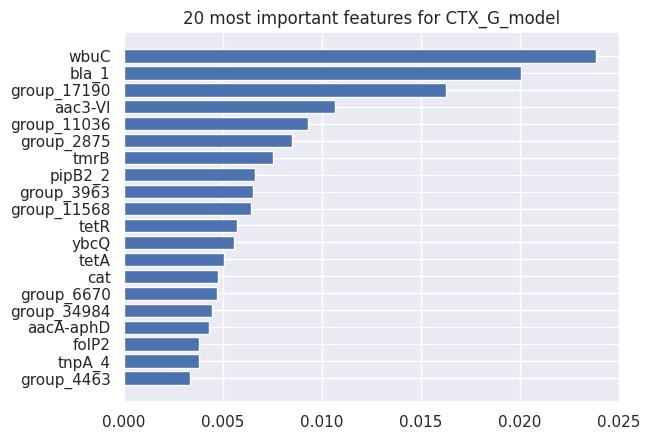

In [19]:
# getting feature importance for our Random Forest model trained using G feature combo for CTX drug
importance = RF_CTX_G_model.feature_importances_

# getting the 20 highest feature importance out of all G features
indices = np.argsort(importance)[-20:]
highest_feat_importance = importance[indices]

# create a barchart of the 20 most important features
sns.set_theme()
plt.barh([x for x in range(len(highest_feat_importance))], highest_feat_importance, tick_label=CTX_G_train_df.iloc[:,1:17199].columns[indices])
plt.title("20 most important features for CTX_G_model")

# saving feature importance bargraph and display in notebook
plt.savefig('/content/drive/My Drive/EColi_ML_Plots/RF_CTX_G_feat_importance.jpg',dpi=400, bbox_inches="tight")
plt.show()

Based on the feature importance bar chart it seems that considering all Accessory genes, the gene **wbuC** seems to have the highest importance in this particular model for the antibiotic CTX. This probably means that strains with this gene are more likely to be resistant to the drug Cefotaxime (CTX).

Note that this doesn't mean that wbuC causes resistance. [This paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8265643/) (fig 2) shows that wbuC may be located right next to the mcr1 gene on a plasmid. The association with mcr1 may be what makes wbuC a good predictor for resistance.

### **8) (OPTIONAL) Hyperparameter Tuning and Crossvalidation for RF model**

This section of the notebook is optional.
Here we will carry out hyperparameter tuning using cross-validation to optimize the model's performance and ensure its robustness. We will also include code to use a blocked cross-validation design. These approaches are important to make good ML models. However, if you are just here to learn the basics, feel free to skip section 8.

#### **a) Hyperparameter Tuning**

The results using our RF model with default features seem to already perform quite well, However we can always see if it can do better, specially for R recall score. For a complete list of of the hyperparameters available for Random Forests click [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). This time we will tune the number of estimators (n_estimators). A higher number of trees decreases the risk for overfitting as it does not increase generalization error based on the mathematical details of this model (which we won't discuss here). It is important to note that the more number of trees the higher the computational resources use, most of the time people leave the number of trees to be the default value (100), however just as an example we have listed up to 300 trees.

In [20]:
# performing hyperparameter tuning for model
## Creating dictionary of parameters to tune.
hparam = {"n_estimators":[50, 100, 200, 300]}

#### **b) Crossvalidation**

In [21]:
# Creating function to perform hyper parameter tuning of model
def RF_hp_tune(param, feat_train_df, lab_train, v=3, cv=4):
  # creating Random Forest model
  model = RandomForestClassifier(random_state = 42)
  # performing the hyper parameter tuning using crossvalidation
  scoring_dic = {'f1_macro':make_scorer(f1_score , average='macro')}
  # isolating the features used for training
  feat = feat_train_df.drop(columns=["MLST"])
  # tranforming labels from letters to 0 & 1
  lab_train_t = lab_train.replace({'R': 0, 'S': 1})
  # Fitting using grid search parameters depending on crossvalidation scheme used
  if str(cv).isnumeric():
    cv = KFold(cv)
    gs = GridSearchCV(model, param, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat, lab_train_t)
  elif cv == "blocked":
    groups= feat_train_df['MLST']
    cv = StratifiedGroupKFold(n_splits=4)
    gs = GridSearchCV(model, param, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat, lab_train_t, groups=groups)
  else:
    print("Please provide a valid crossvalidation scheme `blocked` or an integer")
  print(gs.best_params_)
  print(gs.best_score_)
  return gs.best_estimator_

In [22]:
# Running the function created (takes longer time)
RF_tuned = RF_hp_tune(hparam, CTX_G_train_df, CTX_Train_test_dic['labels_train'])

/tmp/ipython-input-2777474935.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lab_train_t = lab_train.replace({'R': 0, 'S': 1})


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END n_estimators=50; f1_macro: (train=1.000, test=0.915) total time=   0.6s
[CV 2/4] END n_estimators=50; f1_macro: (train=1.000, test=0.895) total time=   0.8s
[CV 3/4] END n_estimators=50; f1_macro: (train=0.999, test=0.897) total time=   0.9s
[CV 4/4] END n_estimators=50; f1_macro: (train=1.000, test=0.896) total time=   0.6s
[CV 1/4] END n_estimators=100; f1_macro: (train=1.000, test=0.923) total time=   1.0s
[CV 2/4] END n_estimators=100; f1_macro: (train=1.000, test=0.886) total time=   1.0s
[CV 3/4] END n_estimators=100; f1_macro: (train=1.000, test=0.917) total time=   1.0s
[CV 4/4] END n_estimators=100; f1_macro: (train=1.000, test=0.891) total time=   1.0s
[CV 1/4] END n_estimators=200; f1_macro: (train=1.000, test=0.923) total time=   1.8s
[CV 2/4] END n_estimators=200; f1_macro: (train=1.000, test=0.900) total time=   1.9s
[CV 3/4] END n_estimators=200; f1_macro: (train=1.000, test=0.916) total time=   2.2

In this case we see that in terms of number of trees used for the Random Forest, the best average f1-score for R and S is obtained with 200 trees, when the model is using only the Accessory genes presence/absence features (**G**) to make predictions for CTX.

### **9) Use all functions and evaluate every drug in every feature combination!**

**NOTE:** Code below is the same as in previous notebook

#### **a) Lets recall the list of drugs we have available and the combination of features we are interested in**

In [23]:
# let's check all drugs
drug_list = All_Drugs_df.iloc[:,3:15].columns
print(drug_list)

# let's see all combinations we are interested in
print(combo_list)

Index(['CTZ', 'CTX', 'AMP', 'AMX', 'AMC', 'TZP', 'CXM', 'CET', 'GEN', 'TBM',
       'TMP', 'CIP'],
      dtype='object')
['Y', 'G', 'GY']


#### **b) Create a loop that will go through all our functions using the lists above**

In [24]:
for fname in os.listdir(filepath):
    if fname.endswith('RF_metrics_df.csv'):
        print("A csv with stored results for Random Forest has already been created. Please check your Google Drive directory.")
        break
else:
  # Lets use all our functions this time and save our report into a single data structure
  RF_model_metrics = {}

  for drug in drug_list:
    print(drug)
    # splits each drug df into a dictionary with testing and training data
    Test_Train_dic = Split_train_test_antibiotic(drug)
    for combo in combo_list:
      # Training each drug and combo features
      labels_train = Test_Train_dic["labels_train"]
      # create corresponding feature_df for training
      features_train = combo_feat(Test_Train_dic["features_train"], drug, combo)
      print(drug+"_"+combo)

      # runs RF model using the corresponding training feature_df and does hyperparameter tuning to get best model
      RF_combo_model = run_RF(features_train, labels_train, drug, combo)

      #Optional: If you want to use the hyperparamter tuning step 8 use this line instead of the previous one:
      #RF_combo_model = RF_hp_tune(hparam, features_train, labels_train, v=0)

      # create corresponding feature_df for testing
      features_test = combo_feat(Test_Train_dic["features_test"], drug, combo)
      # generate predictions based on the feature combination tested
      labels_pred = predict(RF_combo_model, features_test)
      # loading the actual labels
      labels_test = Test_Train_dic["labels_test"]
      # Evaluating our model
      report = evaluate(RF_combo_model, labels_test, labels_pred, cf=False, show_results=False)
      # Saving the results into a dictionary
      RF_model_metrics[drug+"_"+combo] = report
      print(report)
  # convert dictionary into a dataframe
  RF_metrics = pd.DataFrame.from_dict(RF_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
  RF_metrics = RF_metrics.rename(columns = {'index':'Drug_combo'})

  # saving our metric results into a CSV file
  RF_metrics.to_csv(filepath+"RF_metrics_df.csv", index= False)

CTZ
CTZ_Y
CTZ Training combo: Y
Number of Decicion Trees in RF model: 100
[0.8617021276595744, 0.038461538461538464, 0.9938271604938271, 0.5, 0.8655913978494624]
CTZ_G
CTZ Training combo: G
Number of Decicion Trees in RF model: 100
[0.9095744680851063, 0.4230769230769231, 0.9876543209876543, 0.8461538461538461, 0.9142857142857143]
CTZ_GY
CTZ Training combo: GY
Number of Decicion Trees in RF model: 100
[0.9122340425531915, 0.4230769230769231, 0.9907407407407407, 0.88, 0.9145299145299145]
CTX
CTX_Y
CTX Training combo: Y
Number of Decicion Trees in RF model: 100
[0.8781163434903048, 0.42105263157894735, 1.0, 1.0, 0.8662613981762918]
CTX_G
CTX Training combo: G
Number of Decicion Trees in RF model: 100
[0.9529085872576177, 0.8157894736842105, 0.9894736842105263, 0.9538461538461539, 0.9527027027027027]
CTX_GY
CTX Training combo: GY
Number of Decicion Trees in RF model: 100
[0.9418282548476454, 0.7763157894736842, 0.9859649122807017, 0.9365079365079365, 0.9429530201342282]
AMP
AMP_Y
AMP Trai

### **10) Create a bar graph showing metrics for all drugs using only G features**

Using the CSV we created above with all our results, we will create a bargraph to visualize metrics for every antibiotic that uses the G feature (Gene Presence and Absence). In the graph below we are comparing Accuracy and Recall scores for both classes.

The code below serves to create a new directory to store all our Machine Learning plots and figures created. If you run the code more than once it will let you know that the figure has already been created in the directory.

A directory was already created to store your plot


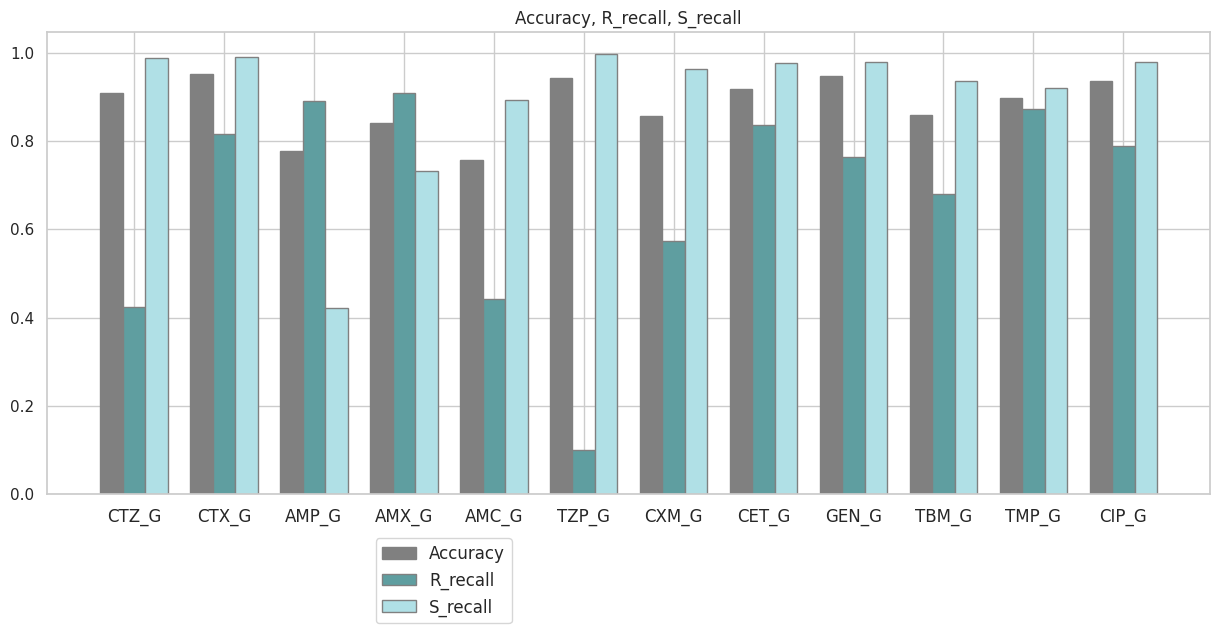

In [25]:
try:
  # makes a directory for all your plot images
  os.mkdir('/content/drive/My Drive/EColi_ML_Plots')
except:
  print("A directory was already created to store your plot")

# filtering for all the rows that contain GY features
RF_metrics = pd.read_csv("/content/drive/MyDrive/EColi_ML_CSV_files/RF_metrics_df.csv")
G_filter = [drug_combo for drug_combo in RF_metrics['Drug_combo'] if drug_combo.endswith("G")]
G_df = RF_metrics.loc[RF_metrics["Drug_combo"].isin(G_filter)]

# Figure Size
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize =(15, 6))

# Adding title
plt.title('Accuracy, R_recall, S_recall', fontsize = 12)

# Variables to be plotted
x = np.arange(len(G_df["Drug_combo"]))
acc = list(G_df["Accuracy"])
R_rec = list(G_df["R_recall"])
S_rec = list(G_df["S_recall"])

# Plotting barcharts
acc_bar=plt.bar(x-0.25, height= acc, width=0.25, color="grey", edgecolor="gray")
rrec_bar=plt.bar(x, height= R_rec, width=0.25, color="cadetblue", edgecolor="gray")
srec_bar=plt.bar(x+0.25, height= S_rec, width=0.25, color="powderblue", edgecolor="gray")

plt.xticks([r for r in range(len(G_df["Drug_combo"]))],
            G_df["Drug_combo"], fontsize = 12)

#legend
fig.legend([acc_bar,rrec_bar,srec_bar],["Accuracy", "R_recall", "S_recall"], bbox_to_anchor=(0.4,-0.35, 0.04, 0.4), fontsize=12)

# Saving bargraph into our new directory
plt.savefig('/content/drive/My Drive/EColi_ML_Plots/RF_G_Accuracy_and_Recall_Scores.jpg',dpi=400, bbox_inches="tight")

# Show Plot
plt.show()

Great! We have created and saved all the Random Forest results for every antibiotic and combination of features we were interested in.

***OPEN QUESTION:***

Look at the graph and compare to the graph you made for the Logistic Regression model. Do the results look the same? If there is a difference, does RF do better or worse than LG?

Now that we have a basic understanding of tree methods in general. It is time to learn about another tree method: [Extreme Gradient Boosted Tree](https://colab.research.google.com/drive/1quEjtE147vchUNEmJubZnvBJ3E1uk5Dk?usp=drive_link).